In [172]:
import cv2
import numpy as np
from scipy import ndimage, misc
from matplotlib import pyplot as plt

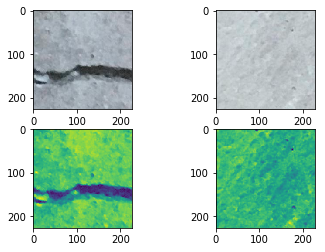

In [173]:
# Function for getting new images
# REMEMBER TO CHANGE THE IMAGE PATH
def new_random_images():
    # Importing a random positive picture (with crack) and a random negative picture 
    pos = cv2.imread("C:\\Users\\Rasmus\\Desktop\\Deep Learning\\concrete_data\\Positive\\{0:05d}.jpg".format(np.random.randint(1,10000)))
    neg = cv2.imread("C:\\Users\\Rasmus\\Desktop\\Deep Learning\\concrete_data\\Negative\\{0:05d}.jpg".format(np.random.randint(1,20000)))

    # Grayscale conversion, opencv uses the following transformation: Y = 0.299*R + 0.587*G +0.114*B
    g_pos = cv2.cvtColor(pos, cv2.COLOR_BGR2GRAY)
    g_neg = cv2.cvtColor(neg, cv2.COLOR_BGR2GRAY)
    
    return pos, g_pos, neg, g_neg

# Copy paste this line into the code segment you want to work with if you don't want to run all the code every time
img_pos, gray_pos, img_neg, gray_neg = new_random_images()

# Plotting original images and grayscale
plt.figure()
plt.subplot(2, 2, 1)
plt.imshow(img_pos)
plt.subplot(2, 2, 2)
plt.imshow(img_neg)
plt.subplot(2, 2, 3)
plt.imshow(gray_pos)
plt.subplot(2, 2, 4)
plt.imshow(gray_neg)

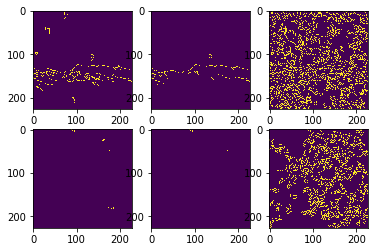

In [174]:
# Applying Canny Edge Detection with different threshold values for the hysteresis thresholding.
# For an explanation of the Canny Edge Detector see https://docs.opencv.org/3.4/da/d5c/tutorial_canny_detector.html 
# or this guy at https://www.youtube.com/watch?v=sRFM5IEqR2w
canny_edges_pos1 = cv2.Canny(gray_pos, 50, 180)
canny_edges_neg1 = cv2.Canny(gray_neg, 50, 180)

canny_edges_pos2 = cv2.Canny(gray_pos, 125, 250)
canny_edges_neg2 = cv2.Canny(gray_neg, 125, 250)

canny_edges_pos3 = cv2.Canny(gray_pos, 0, 70)
canny_edges_neg3 = cv2.Canny(gray_neg, 0, 70)
 

# Plotting the images 3x2, the top row contains the crack images
plt.figure()
plt.subplot(2, 3, 1)
plt.imshow(canny_edges_pos1)
plt.subplot(2, 3, 4)
plt.imshow(canny_edges_neg1)
plt.subplot(2, 3, 2)
plt.imshow(canny_edges_pos2)
plt.subplot(2, 3, 5)
plt.imshow(canny_edges_neg2)
plt.subplot(2, 3, 3)
plt.imshow(canny_edges_pos3)
plt.subplot(2, 3, 6)
plt.imshow(canny_edges_neg3)


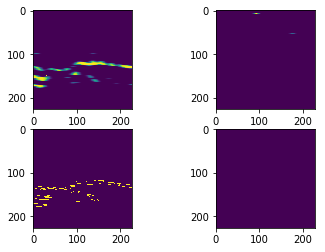

In [175]:
# Laplactian of Guassian (LoG) applied to each picture.
# For explanation see https://homepages.inf.ed.ac.uk/rbf/HIPR2/log.htm
log_pos = ndimage.gaussian_laplace(gray_pos, sigma=4)
log_neg = ndimage.gaussian_laplace(gray_neg, sigma=4)

# Canny Edges is applied to the output of LoG
log_canny_edges_pos = cv2.Canny(log_pos, 130, 220)
log_canny_edges_neg = cv2.Canny(log_neg, 130, 220)

# The LoG uses scipy, opencv version is more manual (applying guassian -> then laplace filter)
# I'm not very confident in the theory behind LoG and how it is best used, if might be something we should further investigate.
# Also some more research into the output of these operations could provide inspiration towards new feature extraction. 

plt.figure()
plt.subplot(2, 2, 1)
plt.imshow(log_pos)
plt.subplot(2, 2, 2)
plt.imshow(log_neg)

plt.subplot(2, 2, 3)
plt.imshow(log_canny_edges_pos)
plt.subplot(2, 2, 4)
plt.imshow(log_canny_edges_neg)

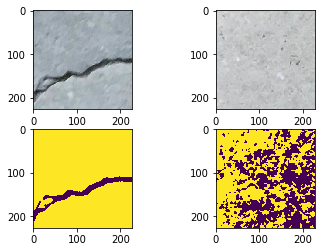

In [177]:
img_pos, gray_pos, img_neg, gray_neg = new_random_images()

# Otsu's binarisation.
# First a Gaussian Blue is applied. The thresholding works by Otsu's method calculates the threshold, 
# then whatever thresholding method we choose is applied (here it is THRESH_BINARY). 
# The returned values is the found threshold and the thresholded image-
blur_pos = cv2.GaussianBlur(gray_pos,(5,5),0)
ret_pos, thresh_pos = cv2.threshold(blur_pos,0,1,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

blur_neg = cv2.GaussianBlur(gray_neg,(5,5),0)
ret_neg, thresh_neg = cv2.threshold(blur_neg,0,1,cv2.THRESH_BINARY+cv2.THRESH_OTSU)


plt.figure()
plt.subplot(2, 2, 1)
plt.imshow(img_pos)
plt.subplot(2, 2, 2)
plt.imshow(img_neg)
plt.subplot(2, 2, 3)
plt.imshow(thresh_pos)
plt.subplot(2, 2, 4)
plt.imshow(thresh_neg)


In [178]:
# Calculating mean intensity of all 0 values of the thresholded image (the potential crack region)

def mean_int(im, im_bin, key):
    (h,w) = im.shape
    (mean, stdev) = (0, 0)
    vals = []
    for i in range(h):
        for j in range(w):
            if im_bin[i,j] == key:
                vals.append(im[i,j])
                
    mean = sum(vals) / len(vals)   
    stdev = sum([abs(x - mean) for x in vals]) / len(vals)
    
    return mean, stdev
            
                
print("Intensity (mean, stdev) for the positive image is {}".format(mean_int(gray_pos, thresh_pos, 0)))
print("Intensity (mean, stdev) for the negative image is {}".format(mean_int(gray_neg, thresh_neg, 0)))

Intensity (mean, stdev) for the positive image is (83.44196572906563, 22.404087993611846)
Intensity (mean, stdev) for the negative image is (189.5274959010945, 4.460591822338371)


For EROSION
Intensity (mean, stdev) for the positive image is (63.671826625387, 12.703153805110164)
Intensity (mean, stdev) for the negative image is (185.8713503649635, 5.285718804944372)
For OPENING: EROSION -> DILATION
Intensity (mean, stdev) for the positive image is (80.549569771792, 21.733419044472026)
Intensity (mean, stdev) for the negative image is (188.18339639439128, 4.861568226242237)


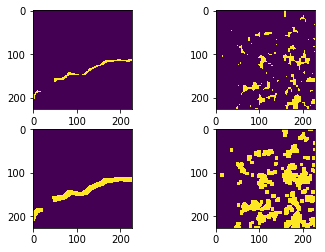

In [179]:
inv_thresh_pos = np.bitwise_not(thresh_pos)
inv_thresh_neg = np.bitwise_not(thresh_neg)

kernel = np.ones((7,7),np.uint8)

erosion_pos = cv2.erode(inv_thresh_pos, kernel, iterations = 1)
erosion_neg = cv2.erode(inv_thresh_neg, kernel, iterations = 1)

open_pos = cv2.morphologyEx(inv_thresh_pos, cv2.MORPH_OPEN, kernel)
open_neg = cv2.morphologyEx(inv_thresh_neg, cv2.MORPH_OPEN, kernel)

print("For EROSION")
print("Intensity (mean, stdev) for the positive image is {}".format(mean_int(gray_pos, erosion_pos, 255)))
print("Intensity (mean, stdev) for the negative image is {}".format(mean_int(gray_neg, erosion_neg, 255)))

print("For OPENING: EROSION -> DILATION")
print("Intensity (mean, stdev) for the positive image is {}".format(mean_int(gray_pos, open_pos, 255)))
print("Intensity (mean, stdev) for the negative image is {}".format(mean_int(gray_neg, open_neg, 255)))


plt.figure()
plt.subplot(2, 2, 1)
plt.imshow(erosion_pos)
plt.subplot(2, 2, 2)
plt.imshow(erosion_neg)
plt.subplot(2, 2, 3)
plt.imshow(open_pos)
plt.subplot(2, 2, 4)
plt.imshow(open_neg)

Gradient (mean, stdev) for the positive image is (0.7133041848844472, 14.490560826091968)
Gradient (mean, stdev) for the negative image is (0.2213383247543285, 10.766811064890792)


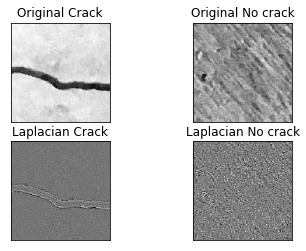

In [133]:
#img_pos, gray_pos, img_neg, gray_neg = new_random_images()

laplacian_pos = cv2.Laplacian(gray_pos, cv2.CV_64F, ksize=3)
laplacian_neg = cv2.Laplacian(gray_neg, cv2.CV_64F, ksize=3)

print("Gradient (mean, stdev) for the positive image is {}".format(mean_int(laplacian_pos, thresh_pos)))
print("Gradient (mean, stdev) for the negative image is {}".format(mean_int(laplacian_neg, thresh_neg)))

plt.subplot(2,2,1),plt.imshow(gray_pos,cmap = 'gray')
plt.title('Original Crack'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,2),plt.imshow(gray_neg,cmap = 'gray')
plt.title('Original No crack'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,3),plt.imshow(laplacian_pos,cmap = 'gray')
plt.title('Laplacian Crack'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,4),plt.imshow(laplacian_neg,cmap = 'gray')
plt.title('Laplacian No crack'), plt.xticks([]), plt.yticks([]);

Intensity (mean, stdev) for the positive image is (75.52937204591493, 15.855302661075951)
Intensity (mean, stdev) for the negative image is (160.7692153562555, 4.7773014312357125)
Gradient (mean, stdev) for the positive image is (25.444800810263335, 27.560199335632465)
Gradient (mean, stdev) for the negative image is (6.3254788811413, 7.033725056427964)


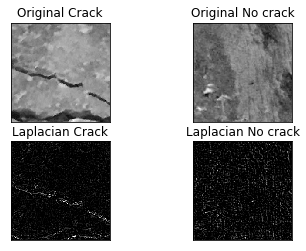

In [153]:
img_pos, gray_pos, img_neg, gray_neg = new_random_images()

# Otsu's binarisation.
# First a Gaussian Blue is applied. The thresholding works by Otsu's method calculates the threshold, 
# then whatever thresholding method we choose is applied (here it is THRESH_BINARY). 
# The returned values is the found threshold and the thresholded image-
blur_pos = cv2.GaussianBlur(gray_pos,(5,5),0)
ret_pos, thresh_pos = cv2.threshold(blur_pos,0,1,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

blur_neg = cv2.GaussianBlur(gray_neg,(5,5),0)
ret_neg, thresh_neg = cv2.threshold(blur_neg,0,1,cv2.THRESH_BINARY+cv2.THRESH_OTSU)


plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(thresh_pos)
plt.subplot(1, 2, 2)
plt.imshow(thresh_neg)
                
print("Intensity (mean, stdev) for the positive image is {}".format(mean_int(gray_pos, thresh_pos)))
print("Intensity (mean, stdev) for the negative image is {}".format(mean_int(gray_neg, thresh_neg)))

laplacian_pos = cv2.Laplacian(gray_pos, cv2.CV_8U, ksize=3)
laplacian_neg = cv2.Laplacian(gray_neg, cv2.CV_8U, ksize=3)

print("Gradient (mean, stdev) for the positive image is {}".format(mean_int(laplacian_pos, thresh_pos)))
print("Gradient (mean, stdev) for the negative image is {}".format(mean_int(laplacian_neg, thresh_neg)))

plt.subplot(2,2,1),plt.imshow(gray_pos,cmap = 'gray')
plt.title('Original Crack'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,2),plt.imshow(gray_neg,cmap = 'gray')
plt.title('Original No crack'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,3),plt.imshow(laplacian_pos,cmap = 'gray')
plt.title('Laplacian Crack'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,4),plt.imshow(laplacian_neg,cmap = 'gray')
plt.title('Laplacian No crack'), plt.xticks([]), plt.yticks([]);